In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [5]:
CSV_FILE = r"C:\Users\hinat\PROJECTS\Financial_Engineering_Projects_HT\Continuously_compounded_Discount_rates_from_CouponBearing_USTreasury_Bonds\Data\US_Treasury_Data.csv"
df = pd.read_csv(CSV_FILE, parse_dates=['Issue Date', 'Maturity'])
bonds_df = df.rename(columns=lambda s: s.strip())
bonds_df.info()
bonds = bonds_df.copy()
bonds['MidPrice'] = (bonds['Bid Price'] + bonds['Ask Price']) / 2.0
bonds['CouponRate'] = bonds['Cpn'] / 100.0
bonds['Face'] = 100.0
bonds['Frequency'] = 2  # semiannual coupons

# Quotation/Settlement date
settle = pd.Timestamp("2025-02-25")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Issuer Name  347 non-null    object        
 1   Issue Date   347 non-null    datetime64[ns]
 2   Maturity     347 non-null    datetime64[ns]
 3   Bid Price    347 non-null    float64       
 4   Ask Price    347 non-null    float64       
 5   Cpn          347 non-null    float64       
 6   Currency     347 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 19.1+ KB


In [6]:
# --- helpers ---------------------------------------------------------------
def generate_coupon_dates(maturity, freq=2, settle=settle):
    """Generate all coupon dates after settlement until maturity."""
    months = 12 // freq
    dates, d = [], maturity
    while d > settle:
        dates.append(d)
        d -= relativedelta(months=months)
    return sorted(dates)

def year_frac(start, end):
    """Actual/365 daycount convention."""
    return (end - start).days / 365.0

# --- build cashflows & accrued --------------------------------------------
bond_cashflows = []
for i, row in bonds.iterrows():
    maturity = pd.Timestamp(row['Maturity'])
    issue = pd.Timestamp(row['Issue Date'])
    freq, face = row['Frequency'], row['Face']
    coupon_rate = row['CouponRate']
    coupon_amt = face * coupon_rate / freq
    coupon_dates = generate_coupon_dates(maturity, freq=freq)
    times = [year_frac(settle, d) for d in coupon_dates]

    # accrued interest: fraction of current period elapsed × coupon
    months = 12 // freq
    full_dates, d = [], maturity
    while d > issue - relativedelta(years=1):
        full_dates.append(d)
        d -= relativedelta(months=months)
        if len(full_dates) > 200: break
    full_dates = sorted(full_dates)

    last_coupon = max([d for d in full_dates if d <= settle], default=issue)
    next_coupon = min([d for d in full_dates if d > settle], default=maturity)
    accrual_frac = year_frac(last_coupon, settle) / year_frac(last_coupon, next_coupon)
    accrued_interest = coupon_amt * accrual_frac

    bond_cashflows.append({
        'idx': i,
        'coupon_dates': coupon_dates,
        'times': times,
        'coupon_amount': coupon_amt,
        'face': face,
        'accrued_interest': accrued_interest
    })

# time range used later for plots
all_times = [t for b in bond_cashflows for t in b['times'] if t > 0]
min_t, max_t = min(all_times), max(all_times)

# curve, pricing, objective

def r_t_vec(t_array, params):
    # Custom zero curve (cont. comp.): a + b t + c t^2 + d e^{f t} + g log(t - h).
    a, b, c, d, f, g, h = params
    t_array = np.array(t_array, dtype=float)
    safe = np.maximum(t_array - h, 1e-8)
    return a + b*t_array + c*t_array**2 + d*np.exp(f*t_array) + g*np.log(safe)

def discount_factors(t_array, params):
    # DF(t) under continuous compounding."""
    return np.exp(-r_t_vec(t_array, params) * np.array(t_array))

def fitted_clean_price(bidx, params):
    # Clean = Dirty − Accrued; Dirty = PV(coupons) + PV(face).
    info = bond_cashflows[bidx]
    times, coupon, face = info['times'], info['coupon_amount'], info['face']
    if not times: return 0, 0, [], []
    dfs = discount_factors(times, params)
    dirty = np.sum(coupon * dfs) + face * dfs[-1]
    clean = dirty - info['accrued_interest']
    return clean, dirty, dfs, info['coupon_dates']

# Objective: minimizing Mean Sum of Squared Errors on MidPrice
market_prices = bonds['MidPrice'].values

def objective(params):
    if params[6] >= min_t:
        return 1e9
    return sum((fitted_clean_price(i, params)[0] - market_prices[i])**2 for i in range(len(bonds)))

x0 = [0.02, 0.0, 0.0, 0.01, -0.1, 0.0, -0.1]
bounds = [(-0.5,0.5), (-5,5), (-5,5), (-10,10), (-5,5), (-10,10), (-10, min_t-1e-6)]
res = minimize(objective, x0, method="L-BFGS-B", bounds=bounds, options={'maxiter':20000})
params_opt = res.x

In [7]:
#  outputs 
fitted_prices, cashflow_rows = [], []
for i in range(len(bonds)):
    info = bond_cashflows[i]
    clean, dirty, dfs, dates = fitted_clean_price(i, params_opt)
    fitted_prices.append(clean)
    for j, (d, t, df) in enumerate(zip(dates, [year_frac(settle, x) for x in dates], dfs)):
        if j == len(dates) - 1:
            cf = info['coupon_amount'] + info['face']
        else:
            cf = info['coupon_amount']
        cashflow_rows.append({
            'BondIdx': i,
            'CashflowDate': pd.Timestamp(d),
            't_years': t,
            'DiscountFactor': df,
            'ContinuouslyCompoundedRate_r(t)': -np.log(df)/t if t>0 else np.nan,
            'Cashflow': cf
        })

bonds['FittedPrice'] = fitted_prices
bonds['Residual'] = bonds['FittedPrice'] - bonds['MidPrice']

cf_df = pd.DataFrame(cashflow_rows).sort_values(['BondIdx','t_years']).reset_index(drop=True)

# Save results with full timestamps
bonds.to_csv("Model01_bond_details.csv", index=False)
cf_df.to_csv("Model01_cashflows.csv", index=False)

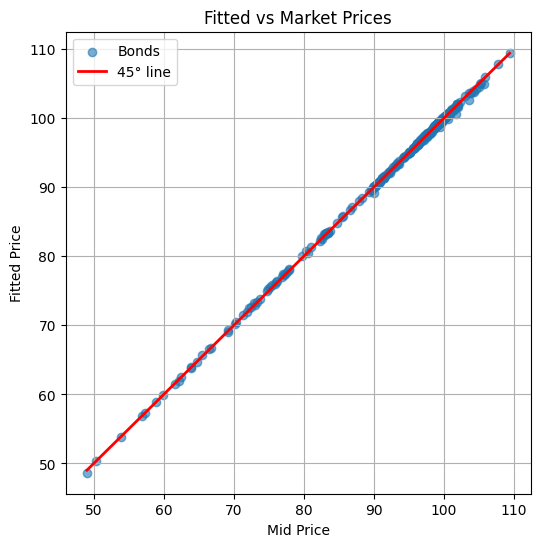

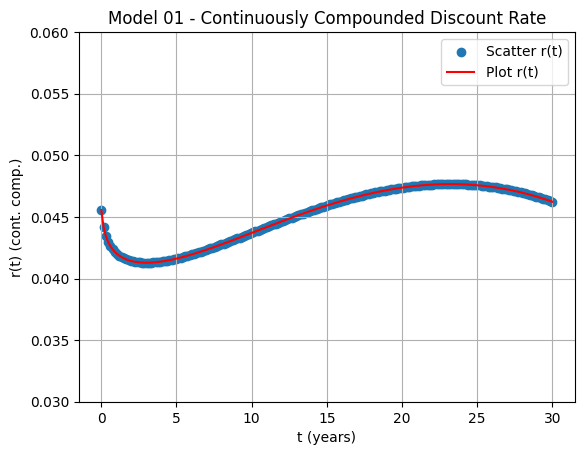

In [8]:
# plots 
# (1) Fitted vs Market bond prices
plt.figure(figsize=(6,6))
plt.scatter(bonds['MidPrice'], bonds['FittedPrice'], alpha=0.6, label="Bonds")
plt.plot([bonds['MidPrice'].min(), bonds['MidPrice'].max()],
         [bonds['MidPrice'].min(), bonds['MidPrice'].max()],
         'r-', lw=2, label="45° line")
plt.xlabel("Mid Price")
plt.ylabel("Fitted Price")
plt.legend()
plt.title("Fitted vs Market Prices")
plt.grid(True)
plt.show()

# (2) Implied r(t)
t_grid = np.linspace(0.01, max_t, 200)
plt.scatter(t_grid, r_t_vec(t_grid, params_opt), label='Scatter r(t)')
plt.plot(t_grid, r_t_vec(t_grid, params_opt),'r-', label='Plot r(t)')
plt.xlabel("t (years)")
plt.ylabel("r(t) (cont. comp.)")
plt.title("Model 01 - Continuously Compounded Discount Rate")
plt.grid(True)
plt.legend()
plt.ylim(0.03, 0.06)
plt.show()

In [9]:
names = ['a','b','c','d','f','g','h']
print(" | ".join(f"{n}={v:.6f}" for n, v in zip(names, params_opt)))

mse_value = np.mean((bonds['FittedPrice'] - bonds['MidPrice'])**2)
print("MSSE =", mse_value)

a=0.024070 | b=0.002084 | c=-0.000040 | d=0.017769 | f=-0.098615 | g=-0.001683 | h=-0.100025
MSSE = 0.030294857380795452
